In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

┌ Info: Precompiling ReactiveMPPaperExperiments [adcd1038-27e6-4580-819b-caa5dba07e45]
└ @ Base loading.jl:1342
┌ Warning: Package ReactiveMPPaperExperiments does not have ReactiveMP in its dependencies:
│ - If you have ReactiveMPPaperExperiments checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMPPaperExperiments
└ Loading ReactiveMP into ReactiveMPPaperExperiments from project dependency, future warnings for ReactiveMPPaperExperiments are suppressed.


In [3]:
using Distributions
using Turing
using Random
using BenchmarkTools
using CairoMakie
using ProgressMeter, DataFrames, Query

In [4]:
@model HGF(y, zt_min_mean, zt_min_std, xt_min_mean, xt_min_std, k, w, z_std, y_std) = begin
    # Priors
    zt_min ~ Normal(zt_min_mean, zt_min_std)
    xt_min ~ Normal(xt_min_mean, xt_min_std)

    zt ~ Normal(zt_min, z_std)
    xt ~ Normal(xt_min, sqrt(exp(k * zt + w)))

    y ~ Normal(xt, y_std)
end

HGF (generic function with 2 methods)

In [5]:
params = let 
    
    seed = 12
    n    = 250
    τ_z  = 20.0
    τ_y  = 5.0
    
    κ = 1.0
    ω = 0.0

    @strdict seed n τ_z τ_y κ ω
end;

In [6]:
z, x, y = generate_data(HGFModel(), params);

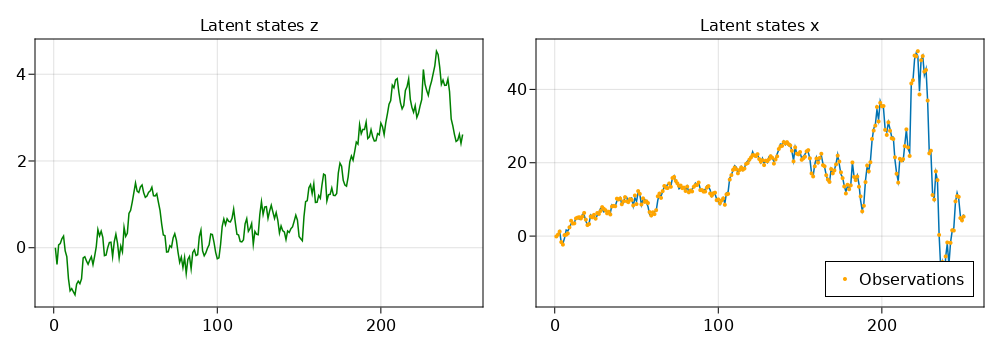

In [7]:
let 
    f = Figure(resolution = (1000, 350))
    
    range = 1:length(z)
    
    ax1 = Axis(f[1, 1], title = "Latent states z")
    ax2 = Axis(f[1, 2], title = "Latent states x")
    
    lines!(ax1, range, z, color = :green)
    
    lines!(ax2, range, x)
    scatter!(ax2, range, y, label = "Observations", markersize = 4, color = :orange)
    
    axislegend(ax2, position = :rb)
    
    f
end

In [8]:
function extract_params_for_next_step(chain)
    sumstats = Turing.summarize(chain, Turing.mean, Turing.std)
    
    xt_index = findnext(e -> e === :xt, sumstats.nt.parameters, 1)
    zt_index = findnext(e -> e === :zt, sumstats.nt.parameters, 1)
    
    return (
        xt_min_mean = sumstats.nt.mean[xt_index],
        xt_min_std  = sumstats.nt.std[xt_index],
        zt_min_mean = sumstats.nt.mean[zt_index],
        zt_min_std  = sumstats.nt.std[zt_index],
    )
end


extract_params_for_next_step (generic function with 1 method)

In [9]:
function inference(y, params; nsamples = 100, method = HMC(0.1, 10))
    @unpack seed, κ, ω, τ_z, τ_y = params
    
    z_std = inv(sqrt(τ_z))
    y_std = inv(sqrt(τ_y))
    
    rng = MersenneTwister(seed)
    
    zt_min_mean = 0.0
    zt_min_std  = sqrt(5.0)
    xt_min_mean = 0.0
    xt_min_std  = sqrt(5.0)
    
    results = []
    
    @showprogress for i in 1:length(y)
        
        chain = sample(rng, HGF(y[i], zt_min_mean, zt_min_std, xt_min_mean, xt_min_std, κ, ω, z_std, y_std), method, nsamples);
        stats = extract_params_for_next_step(chain)
        
        zt_min_mean = stats[:zt_min_mean]
        xt_min_mean = stats[:xt_min_mean]
        zt_min_std = stats[:zt_min_std]
        xt_min_std = stats[:xt_min_std]
        
        push!(results, stats)
    end
    
    return results
end

inference (generic function with 1 method)

In [10]:
Turing.setprogress!(false)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/bvdmitri/.julia/packages/Turing/uMQmD/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /Users/bvdmitri/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


false

In [32]:
results = inference(y, params; nsamples = 2000, method = HMC(0.01, 20));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


In [33]:
function extract_stats(results, sym::Symbol)
    return map(i -> i[sym], results)
end

extract_stats (generic function with 1 method)

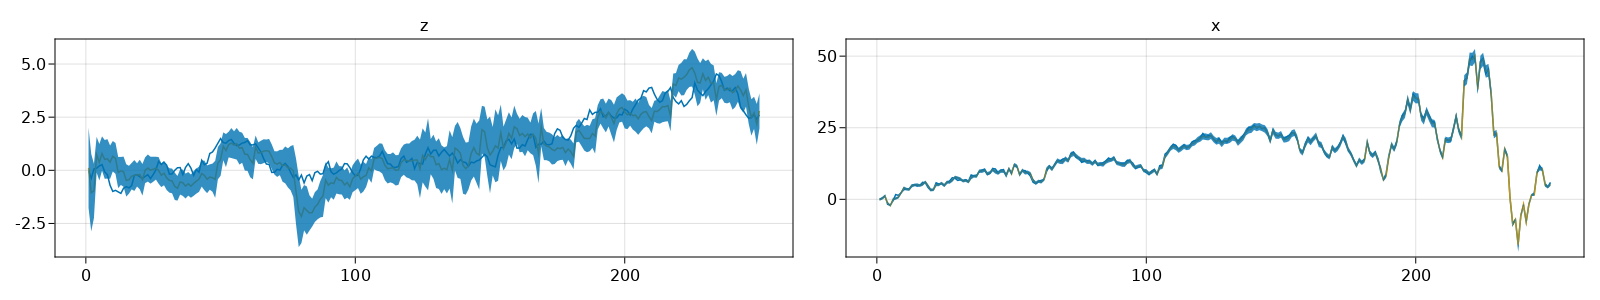

In [35]:
let
    f = Figure(resolution = (1600, 300))
    
    ax1 = Axis(f[1, 1], title = "z")
    ax2 = Axis(f[1, 2], title = "x")
    
    n = length(z)
    
    z_mean = extract_stats(results, :zt_min_mean)
    z_std  = extract_stats(results, :zt_min_std)
    
    lines!(ax1, 1:n, z)
    lines!(ax1, 1:n, z_mean)
    band!(ax1, 1:n, z_mean .- z_std, z_mean .+ z_std)
    
    x_mean = extract_stats(results, :xt_min_mean)
    x_std  = extract_stats(results, :xt_min_std)
    
    lines!(ax2, 1:n, x)
    lines!(ax2, 1:n, x_mean)
    band!(ax2, 1:n, x_mean .- x_std, x_mean .+ x_std)
    
    f
end

In [36]:
function _average_mse(states, estimated::AbstractVector, symbol::Symbol)
    average = zero(first(states))

    e_means = map(e -> e[Symbol(symbol, :t_min_mean)], estimated)
    e_stds  = map(e -> e[Symbol(symbol, :t_min_std)], estimated)
    
    dists = map(e -> Normal(e...), zip(e_means, e_stds))
    
    return mapreduce(+, zip(states, estimated)) do (s, e)
        return var(e) + abs2(s - mean(e))
    end
end

_average_mse (generic function with 1 method)

In [37]:
function run_benchmark(params)
    @unpack seed, n, nsamples, κ, ω, τ_z, τ_y = params

    z, s, y = generate_data(HGFModel(), params);
    
    method = HMC(0.01, 20);

    results    = inference(y, params; nsamples = nsamples, method = method);
    benchmark  = @benchmark inference($y, $params; nsamples = $nsamples, method = $method);
    
    z_amse = _average_mse(z, results, :z)
    s_amse = _average_mse(s, results, :x)

    output = @strdict n seed nsamples τ_z τ_y κ ω results benchmark z_amse s_amse

    return output
end

run_benchmark (generic function with 1 method)

In [38]:
benchmark_params = dict_list(Dict(
    "n"         => [ 50, 100, 250 ],
    "nsamples"  => [ 250, 500, 1000, 2000, 5000 ],
    "seed"  => 12,
    "τ_z"   => 20.0,
    "τ_y"   => 5.0,
    "κ"     => 1.0,
    "ω"     => 0.0,
));

In [40]:
# First run maybe slow, you may track the progress in the terminal
# Subsequent runs will not create new benchmarks 
# but will reload it from data folder
turing_benchmarks = map(benchmark_params) do params
    path = datadir("benchmark", "hgf", "turing")
    result, _ = produce_or_load(path, params; tag = false) do p
        run_benchmark(p)
    end
    return result
end;

In [49]:
target_seed = 12
target_nsamples = 500

500

In [50]:
let
    path = datadir("benchmark", "hgf", "turing")

    white_list   = [ "n", "seed", "nsamples", "z_amse", "s_amse" ]
    special_list = [
        :min => (data) -> string(round(minimum(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :mean => (data) -> string(round(mean(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :gctime => (data) -> string(round(minimum(data["benchmark"]).gctime / minimum(data["benchmark"]).time * 100, digits = 2), "%"),
    ]

    df = collect_results(path, white_list = white_list, special_list = special_list, verbose = false)

    query = @from row in df begin
        @where row.seed == target_seed && row.nsamples == target_nsamples
        @orderby ascending(row.n)
        @select { row.n, row.min, row.gctime, row.z_amse, row.s_amse }
    end

    DataFrame(query) 
end

┌ Info: Scanning folder /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/hgf/turing for result files.
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/OgRKj/src/result_collection.jl:107


,n,min,gctime,z_amse,s_amse
,Int64?,String?,String?,Float64?,Float64?
1,50,2116.05ms,11.96%,653.833,1544.32
2,100,4138.2ms,11.53%,2744.81,6399.9
3,250,10360.51ms,11.8%,22993.6,58271.0
